### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import seaborn as sns
import subjects

# from neuropy.analyses import detect_local_sleep_epochs

### Bimodality in firing rate during sleep deprivation
- Something similar to Ji and Wilson 2007, to see if we have off periods during sleep deprivation that can clearly be seen as a peak in sleep deprivation.
- Didn't find any bimodality in my data tried using all spikes and only pyramidal neurons.

In [ ]:
from scipy.ndimage import gaussian_filter1d

sessions = subjects.mua_sess()
mua_all = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 5 * 3600]
    # mua = sess.mua.spike_counts
    # mua = np.convolve(mua, np.ones(10), mode="same")[1::10]
    mua = sess.neurons.get_mua(0.01).get_smoothed(0.03).spike_counts
    t_start = sess.mua.t_start
    mua_time = np.arange(len(mua)) * 0.01 + t_start

    noisy_bool = sess.brainstates["NOISE"].get_indices_for_time(mua_time)

    mua_time = mua_time[~noisy_bool]
    mua = mua[~noisy_bool]
    # binspk = (
    #     sess.neurons.get_neuron_type("pyr")
    #     .time_slice(*period)
    #     .get_binned_spiketrains(bin_size=0.1)
    # )
    # n_spikes = binspk.spike_counts.sum(axis=0)
    # mua.append(n_spikes / n_spikes.max())
    mua_all.append(mua)
# mua = np.concatenate(mua)

In [ ]:
_, axs = plt.subplots(5, 4, sharex=True)
axs = axs.reshape(-1)

for i, mua in enumerate(mua_all):
    mua_bins = np.arange(0, 12, 0.01)
    mua_hist = np.histogram(mua, mua_bins)[0]
    mua_hist = mua_hist / len(mua)
    ax = axs[i]
    ax.plot(mua_bins[:-1], mua_hist)
    # ax.fill_between(mua_bins[:-1] + 0.0005, 0, mua_hist)
    # ax.set_xscale("log")

### Pooled off period detection during sleep deprivation only

In [ ]:
from neuropy.analyses import detect_off_epochs

sessions = subjects.sd.ratUday1
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 5 * 3600]
    mua = sess.mua.time_slice(*period)
    smth_mua = mua.get_smoothed(sigma=0.02)

    off = detect_off_epochs(smth_mua)
    off.save(sess.filePrefix.with_suffix(".off"))

### Pooled Off period detection in the entire period 
Criterion (from below + `neuropy.analyses.spkepochs.detect_off_epochs` in line with Vyazovskiy et al. (2011):
1) Smooth pooled MUA activity with a 20ms gaussian across the whole session. 
2) Identify candidate off periods where smoothed firing rate falls below median.
3) From candidate periods, identify the miminimum instantaneous (smoothed) firing MUA rate.
4) Select off periods as those where the minimum instantaneous rate (#3) falls in the bottom 10%. 

In [ ]:
from neuropy.analyses import detect_off_epochs

sessions = subjects.mua_sess()
for sub, sess in enumerate(sessions):
    smth_mua = sess.mua.get_smoothed(sigma=0.02)
    off = detect_off_epochs(smth_mua)
    off.save(sess.filePrefix.with_suffix(".off_epochs"))

### Delete extra long off period

In [ ]:
from neuropy.analyses import detect_off_epochs

sessions = subjects.mua_sess()
for sub, sess in enumerate(sessions):
    off = sess.off_epochs
    off.save(sess.filePrefix.with_suffix(".off_epochs.outliier"))
    new_off = sess.off_epochs.duration_slice(max_dur=5)
    new_off.save(sess.filePrefix.with_suffix(".off_epochs"))

### Rate of occurence

In [ ]:
sessions = subjects.mua_sess()

off_df = []
for sub, sess in enumerate(sessions):
    zt_epochs = sess.get_zt_epochs(include_maze=False)
    off = sess.off_epochs.starts

    hist_off = np.histogram(off, bins=zt_epochs.flatten())[0][::2]

    off_df.append(
        pd.DataFrame(
            {
                "rate": hist_off / zt_epochs.durations,
                "zt": zt_epochs.labels,
                # "name": sess.animal.name + sess.animal.day,
                "session": sub,
                "grp": sess.tag,
            }
        ),
    )
off_df = pd.concat(off_df, ignore_index=True)
subjects.GroupData().save(off_df, "off_rate")

In [ ]:
from stats_utils import bootstrap_resample

## Uncomment if you want to re-run the bootstrapping

from stats_utils import bootstrap_resample, resample

rpl_rate = subjects.GroupData().off_rate
func = lambda df: df.groupby(["grp", "zt"], sort=False).mean().reset_index()
rpl_df = bootstrap_resample(
    rpl_rate, level="session", n_iter=10000, n_jobs=1, apply=func
)

subjects.GroupData().save(rpl_df, "off_rate_bootstrap_session")

In [ ]:
from plotters import Plotter
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

rpl_df = subjects.GroupData().off_rate_bootstrap_session
fig = plotting.Fig(6, 7)
ax = fig.subplot(fig.gs[1])
plotter = Plotter(data=rpl_df, x="zt", y="rate", hue="grp", hue_order=["NSD", "SD"])
plotter.violinplot_sd(split=True, palette=subjects.colors_sd(1)).stat_anot_sd(
    stat_across=get_bootstrap_prob,
    stat_within=get_bootstrap_prob_paired,
    alpha_within=0.025,
    alpha_across=0.025,
)

fig.savefig(subjects.figpath_sd / "off_rate1")

In [ ]:
# from plotters import stripbarplot


fig = plotting.Fig(7, 6, constrained_layout=False)

ax = fig.subplot(fig.gs[0])

sns.stripplot(data=off_df, x="zt", y="rate", hue="grp", dodge=True, ax=ax)
ax.set_ylabel("Rate (Hz)")
ax.legend("", frameon=False)
fig.savefig(subjects.figpath_sd / "off_rate")

### Off duration session wise

In [ ]:
sessions = subjects.mua_sess()

off_df = []
for sub, sess in enumerate(sessions):
    zt_epochs = sess.get_zt_epochs(include_maze=False)
    off = sess.off_epochs
    print(np.sum(off.durations > 5))

    for e in zt_epochs.itertuples():
        mean_dur = off.time_slice(e.start, e.stop).durations.mean()
        off_df.append(
            pd.DataFrame(
                {
                    "mean_duration": [mean_dur],
                    "zt": e.label,
                    "session": sub,
                    "grp": sess.tag,
                }
            ),
        )

off_df = pd.concat(off_df, ignore_index=True)
subjects.GroupData().save(off_df, "off_mean_duration")

In [ ]:
from plotters import stripbarplot


fig = plotting.Fig(grid=(7, 6), constrained_layout=False)

ax = fig.subplot(fig.gs[0])

stripbarplot(data=off_df, x="zt", y="mean_duration", ax=ax)
ax.set_ylabel("Rate (Hz)")

# fig.savefig(subjects.figpath_sd / "off_durations")

### Visualize off periods sorted by duration

In [ ]:
rng = np.random.default_rng()
sessions = subjects.mua_sess()
n_off = 100
mua_df = []
for s, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    mua = sess.mua
    smth_mua = mua.get_smoothed(sigma=0.02)
    mua_time = np.round(smth_mua.time, 3)

    if sess.tag == "NSD":
        periods = [[post[0], post[0] + 7.5 * 3600]]
    if sess.tag == "SD":
        periods = [
            [post[0], post[0] + 5 * 3600],
            [post[0] + 5 * 3600, post[0] + 7.5 * 3600],
        ]

    for p, period in enumerate(periods):
        off = sess.off_epochs.time_slice(*period)
        chosen_indx = rng.choice(len(off), n_off)
        chosen_off = off[chosen_indx]
        chosen_starts = np.round(chosen_off.starts, 3)
        chosen_durations = chosen_off.durations

        mua_off_indx = np.searchsorted(mua_time, chosen_starts)
        mua_off_around_indx = [np.arange(i - 100, i + 2000) for i in mua_off_indx]
        mua_around_off = smth_mua.spike_counts[mua_off_around_indx].reshape(n_off, -1)

        df = pd.DataFrame(
            mua_around_off, columns=np.linspace(-0.1, 2, mua_around_off.shape[1])
        )
        df["duration"] = chosen_durations
        if sess.tag == "NSD":
            df["grp"] = "NSD"
        if sess.tag == "SD":
            if p == 0:
                df["grp"] = "SD"
            if p == 1:
                df["grp"] = "RS"

        mua_df.append(df)

mua_df = pd.concat(mua_df, ignore_index=True)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

fig = subjects.SdFig().fig1_supp()

for g, grp in enumerate(["NSD", "SD", "RS"]):
    ax = fig.subplot(fig.gs[g])
    grp_df = mua_df[mua_df.grp == grp]
    dur = grp_df.duration.values
    sort_indx = np.argsort(dur)[::-1]
    zsc_mua = stats.zscore(grp_df.iloc[:, :-2].to_numpy(), axis=1)
    t = np.linspace(-0.1, 2, zsc_mua.shape[1])

    # if g == 0:
    #     cm = fig.get_colormap((0, 0, 0), (1,1,1))
    # # if g == 1:
    # #     cm = fig.get_colormap((0, 0, 0), subjects.colors_sd()[1])
    # # if g == 2:
    # colors = [(0, 0, 0), (1, 1, 1)]  # first color is black, last is red
    # cm = LinearSegmentedColormap.from_list("Custom", colors, N=20)

    ax.pcolormesh(
        t,
        np.arange(800) + 1,
        zsc_mua[sort_indx, :],
        cmap="copper",
        shading="auto",
        rasterized=True,
    )
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([1, 800])

fig.savefig(subjects.figpath_sd / "mua_examples_off_periods", dpi=300, format="svg")

### Off duration/rate first hour vs last hour SD sessions

In [ ]:
sessions = subjects.sd.mua_sess

off_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()

    # ---crosscheck frequently changed params-------
    starts = np.repeat(post[0], 3) + np.array([0, 4, 4.5]) * 3600
    stops = starts + np.array([1, 1, 0.5]) * 3600
    labels = ["0-1", "4-5", "4.5-5"]

    zt_epochs = sess.paradigm.from_array(starts, stops, labels)

    off_epochs = sess.off_epochs.duration_slice(max_dur=2)
    off_starts = off_epochs.starts
    off_durations = off_epochs.durations

    # bins = np.unique(zt_epochs.flatten())
    # off_hist = np.histogram(off_starts, bins=bins)[0][::2]
    # off_stat = stats.binned_statistic(
    #     off_starts, off_durations, bins=bins, statistic="mean"
    # )[0][::2]

    for e in zt_epochs.itertuples():
        indx = (off_starts >= e.start) & (off_starts <= e.stop)
        e_starts = off_starts[indx]
        e_durations = off_durations[indx]

        off_df.append(
            pd.DataFrame(
                {
                    "rate": len(e_starts) / e.duration,
                    "mean_duration": e_durations.mean(),
                    "zt": [e.label],
                    "name": sess.animal.name + sess.animal.day,
                    "grp": sess.tag,
                }
            ),
        )

off_df = pd.concat(off_df, ignore_index=True)
# subjects.GroupData().save(pbe_rate_df,'off_rate')

In [ ]:
from plotters import stripbarplot
from statannotations.Annotator import Annotator

fig = plotting.Fig(grid=(7, 6), constrained_layout=False)

for i, y in enumerate(["mean_duration", "rate"]):
    ax = fig.subplot(fig.gs[i])
    plot_kw = dict(data=off_df, x="zt", y=y, ax=ax)

    sns.stripplot(
        **plot_kw,
        dodge=True,
        edgecolor="w",
        linewidth=0.3,
        size=3,
        palette=[subjects.colors_sd(1)[1]],
    )
    ax.set_ylabel(y)
    ax.set_xlabel("")
    ax.legend("", frameon=False)
    ax.tick_params("x", labelrotation=30)

    orders = off_df.zt.unique()
    pairs2 = [("0-1", "4-5"), ("0-1", "4.5-5")]
    annotator = Annotator(pairs=pairs2, **plot_kw, order=orders)
    annotator.configure(
        test="t-test_paired", **subjects.stat_kw, color=subjects.colors_sd(1)[1]
    )
    annotator.apply_and_annotate()
    annotator.reset_configuration()


fig.savefig(subjects.figpath_sd / "off_durations_sd_first_last_hour")

### Off duration/rate trend during sleep deprivation
- session wise linear regression to see if there is trend from early to late SD

In [ ]:
sessions = subjects.sd.mua_sess

off_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()

    starts = np.repeat(post[0], 5) + np.arange(5) * 3600
    stops = starts + 3600
    # labels = [f'{i}-{i+1}' for i in range(5)]
    labels = [f"{i+1}" for i in range(5)]

    zt_epochs = sess.paradigm.from_array(starts, stops, labels)

    off_epochs = sess.off_epochs.duration_slice(max_dur=2)
    off_starts = off_epochs.starts
    off_durations = off_epochs.durations

    bins = np.unique(zt_epochs.flatten())
    off_hist = np.histogram(off_starts, bins=bins)[0]
    off_stat = stats.binned_statistic(
        off_starts, off_durations, bins=bins, statistic="median"
    )[0]

    # for e in zt_epochs.itertuples():
    #     indx = (off_starts>=e.start)&(off_starts<=e.stop)
    #     e_starts = off_starts[indx]
    #     e_durations = off_durations[indx]

    off_df.append(
        pd.DataFrame(
            {
                "rate": off_hist / zt_epochs.durations,
                "mean_duration": off_stat,
                "zt": zt_epochs.labels,
                "name": sess.animal.name + sess.animal.day,
                "grp": sess.tag,
            }
        ),
    )


off_df = pd.concat(off_df, ignore_index=True)

In [ ]:
from statannotations.Annotator import Annotator

fig = plotting.Fig(grid=(7, 6), constrained_layout=False)

names = off_df.name.unique()

ax = fig.subplot(fig.gs[0])
plot_kw = dict(data=off_df, x="zt", y="mean_duration", ax=ax)

# sns.stripplot(
#     **plot_kw,
#     dodge=True,
#     edgecolor="w",
#     linewidth=0.3,
#     size=3,
#     palette=[subjects.colors_sd(1)[1]],
# )
# ax.set_ylabel('Mean duration (s)')
# ax.set_xlabel("")
# ax.legend("", frameon=False)
# ax.tick_params("x", labelrotation=30)


for i, nm in enumerate(names):
    df = off_df[off_df.name == nm]
    x = df.zt.values.astype("float")
    y = df.rate.values

    linfit = stats.linregress(x, y)
    slope = linfit.slope
    intercept = linfit.intercept
    ax.scatter(x, y, s=20, edgecolors="w")

    color_line = "red" if linfit.pvalue <= 0.05 else "gray"
    ax.plot(x, slope * x + intercept, color=color_line)
    # print(stats.pearsonr(x,y))

ax.set_xticks([1, 2, 3, 4, 5])
x = off_df.zt.values.astype("float")
y = off_df.mean_duration.values
print(stats.pearsonr(x, y))


# fig.savefig(subjects.figpath_sd/'off_duration_trend_sd')

### Off duration distribution

In [ ]:
sessions = subjects.mua_sess()

off_feat_df = []
for sub, sess in enumerate(sessions):
    epochs = sess.get_zt_epochs()[2:]

    off_df = sess.off_epochs.to_dataframe()
    off_starts = off_df.start.values
    off_duration = off_df.duration.values

    for e in epochs.itertuples():
        indx = (off_starts >= e.start) & (off_starts < e.stop)

        off_feat_df.append(
            pd.DataFrame(
                dict(
                    duration=off_duration[indx],
                    zt=e.label,
                    session=sess.animal.name + sess.animal.day,
                    grp=sess.tag,
                )
            )
        )

off_feat_df = pd.concat(off_feat_df, ignore_index=True)
off_feat_df = off_feat_df[off_feat_df.duration < 2]

In [ ]:
from plotters import violinplot
from statannotations.Annotator import Annotator
from neuropy.plotting import Fig

fig = Fig(grid=(5, 5), fontsize=10)
stat_kw = subjects.stat_kw.copy()
stat_kw["fontsize"] = 10


ax = plt.subplot(fig.gs[0])
plot_kw = dict(data=off_feat_df, x="zt", y="duration", inner="quartile", ax=ax)
sns.violinplot(**plot_kw, legend=False, marker="o")

# ax.set_ylim(top=2)
ax.set_xlabel("Zt time (h)")
ax.set_title("Off periods rate")
ax.set_ylabel("Rate (Hz)")
# ax.set_xlim([-1, 2])


pairs = [("0-2.5", "2.5-5")]
orders = off_feat_df.zt.unique()
annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
annotator.configure(test="t-test_welch", **stat_kw, color="k")
annotator.apply_and_annotate()
annotator.reset_configuration()


ax = plt.subplot(fig.gs[0, 1:])
plot_kw = dict(
    data=off_feat_df,
    x="session",
    y="duration",
    hue="zt",
    hue_order=["0-2.5", "2.5-5"],
    ax=ax,
)
violinplot(**plot_kw, legend=False, marker="o")

# ax.set_ylim(top=2)
# ax.set_xlabel("Zt time (h)")
# ax.set_title("Off periods rate")
# ax.set_ylabel("Rate (Hz)")
# ax.set_xlim([-1, 2])

names = off_feat_df.session.unique()
pairs = [((nm, "0-2.5"), (nm, "2.5-5")) for nm in names]
# pairs = [('0-2.5','2.5-5')]
orders = off_feat_df.session.unique()
annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
annotator.configure(test="t-test_welch", **stat_kw, color="k")
annotator.apply_and_annotate()
annotator.reset_configuration()


# fig.savefig(subjects.figpath_sd/'off_duration')

### Off duration distribution

In [ ]:
sessions = subjects.mua_sess()

off_feat_df = []
for sub, sess in enumerate(sessions):
    epochs = sess.get_zt_epochs()[2:]

    off_df = sess.off_epochs.to_dataframe()
    off_starts = off_df.start.values
    off_duration = off_df.duration.values

    for e in epochs.itertuples():
        indx = (off_starts >= e.start) & (off_starts < e.stop)

        off_feat_df.append(
            pd.DataFrame(
                dict(
                    duration=off_duration[indx],
                    zt=e.label,
                    session=sess.animal.name + sess.animal.day,
                    grp=sess.tag,
                )
            )
        )

off_feat_df = pd.concat(off_feat_df, ignore_index=True)
off_feat_df = off_feat_df[off_feat_df.duration < 2]

In [ ]:
from plotters import violinplot
from statannotations.Annotator import Annotator
from neuropy.plotting import Fig

fig = Fig(grid=(5, 5), fontsize=10)
stat_kw = subjects.stat_kw.copy()
stat_kw["fontsize"] = 10


ax = plt.subplot(fig.gs[0])
plot_kw = dict(data=off_feat_df, x="zt", y="duration", hue="grp", ax=ax)
violinplot(**plot_kw, legend=False, marker="o")

# ax.set_ylim(top=2)
ax.set_xlabel("Zt time (h)")
ax.set_title("Off periods rate")
ax.set_ylabel("Rate (Hz)")
# ax.set_xlim([-1, 2])


# pairs = [("0-2.5", "2.5-5")]
# orders = off_feat_df.zt.unique()
# annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
# annotator.configure(test="t-test_welch", **stat_kw, color="k")
# annotator.apply_and_annotate()
# annotator.reset_configuration()

# stats
# Across groups
orders = off_feat_df.zt.unique()
pairs = [((_, "NSD"), (_, "SD")) for _ in orders] + [
    (("0-2.5", "NSD"), ("5-7.5", "SD"))
]
annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
annotator.configure(test="t-test_welch", **stat_kw, color="#4AB33E")
annotator.apply_and_annotate()
annotator.reset_configuration()

# Within groups
for i, g in enumerate(["NSD", "SD"]):
    pairs2 = [((orders[_], g), (orders[_ + 1], g)) for _ in range(2)]
    annotator = Annotator(pairs=pairs2, **plot_kw, order=orders)
    annotator.configure(test="t-test_welch", **stat_kw, color=subjects.colors_sd(1)[i])
    annotator.apply_and_annotate()
    annotator.reset_configuration()

fig.savefig(subjects.figpath_sd / "off_duration_all_sess")

### Total duration during SD

In [ ]:
sessions = subjects.mua_sess()

off_duration = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    zt = np.array([0, 4])
    period = zt * 3600 + post[0]

    for i, t in enumerate(period):
        off_duration.append(
            pd.DataFrame(
                {
                    "Zt": f"Zt{zt[i]}-{zt[i]+1}",
                    "off_duration": [sess.off.time_slice(t, t + 3600).durations.sum()],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
        )

off_duration = pd.concat(off_duration, ignore_index=True)
subjects.GroupData().save(off_duration, "off_total_duration")

In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy import plotting

# plt.figure(figsize=(8,11))
fig = plotting.Fig(grid=(4, 3),fontsize=12)

for i, grp in enumerate(["SD"]):
    data = off_duration[off_duration["grp"] == grp]
    ax = plt.subplot(fig.gs[i])
    sns.lineplot(
        data=data,
        x="Zt",
        y="off_duration",
        hue="sub",
        marker="o",
        palette=["#f94848"] * 7,
        ax=ax,
        legend=None,
    )
    ax.set_xlim([-1,2])

ax.set_xlabel('Zt time (h)')
ax.set_ylabel('Time in off (s)')
ax.set_title('OFF periods during\nsleep deprivation')
# ax.set_ylim([30,450])



### EDF 2H: Off periods vs rpls/pbe CCG
- In the hippocampus following PBE/SWR there is a brief period of silence. When plotting the ccg between ripple-stops and off-starts, we see a clear peak around zero. This suggests, off periods detected include post-SWR silence periods too, making it hard to interpret sleep deprivation-induced off-periods in the hippocampus (unlike what was observed in the cortex in Vyazovskiy et al. 2011).
- One possible way to analayze this can be assessing mua activity within these off-periods and see if later in sleep deprivation if neurons more or less silent compared to earlier in sleep deprivation.

In [2]:
from neuropy.utils.ccg import correlograms

sessions = subjects.mua_sess()
ccg_df = []
for sub, sess in enumerate(sessions):
    zt_epochs = sess.get_zt_epochs()[2:]

    for e in zt_epochs.itertuples():
        period = [e.start, e.stop]
        # Original BG code - seems to be counting ALL delta wave in demoninator
        # off_starts = sess.off_epochs.starts
        # off_stops = sess.off_epochs.stops
        off_starts = sess.off_epochs.time_slice(*period).starts
        off_stops = sess.off_epochs.time_slice(*period).stops
        ndelta = sess.off_epochs.time_slice(*period).n_epochs

        # NRK check code
        # off_starts_nk = sess.off_epochs.time_slice(*period).starts
        # off_stops_nk = sess.off_epochs.time_slice(*period).stops
        
        rpls = sess.ripple.time_slice(*period)
        rpls_t = rpls.to_dataframe().peak_time
        nrip = rpls.n_epochs

        times = np.concatenate([off_starts, off_stops, rpls_t])
        ids = np.concatenate(
            [
                1 * np.ones_like(off_starts),
                2 * np.ones_like(off_stops),
                3 * np.ones_like(rpls_t),
            ]
        )
        sort_ind = np.argsort(times)

        ccg = correlograms(
            times[sort_ind],
            ids[sort_ind].astype("int"),
            sample_rate=1250,
            bin_size=0.001,
            window_size=0.5,
        )

        # NRK code check
        # times_nk = np.concatenate([off_starts_nk, off_stops_nk, rpls_t])
        # ids_nk = np.concatenate(
        #     [
        #         1 * np.ones_like(off_starts_nk),
        #         2 * np.ones_like(off_stops_nk),
        #         3 * np.ones_like(rpls_t),
        #     ]
        # )
        # sort_ind_nk = np.argsort(times_nk)

        # ccg_nk = correlograms(
        #     times_nk[sort_ind_nk],
        #     ids_nk[sort_ind_nk].astype("int"),
        #     sample_rate=1250,
        #     bin_size=0.001,
        #     window_size=0.5,
        # )
        
        ccg_df.append(
            pd.DataFrame(
                {
                    # "ccg_from_start": ccg[0, 2, :] / len(off_starts), # original code divided by total # delta wave across the whole session!
                    # "ccg_from_stop": ccg[1, 2, :] / len(off_stops),
                    "ccg_from_start": ccg[0, 2, :] / ndelta, # new code divides by total # delta wave in each epoch
                    "ccg_from_stop": ccg[1, 2, :] / ndelta,
                    "time": np.linspace(-0.25, 0.25, 501),
                    "zt": e.label,
                    "session": sub,
                    "grp": sess.tag,
                    "nripple_from_start": ccg[0, 2, :],
                    "nripple_from_stop": ccg[1, 2, :],
                    "noffs": len(off_starts),
                    "poff_start|ripple": ccg[2, 0, :] / nrip,
                    "poff_stop|ripple": ccg[2, 1, :] / nrip,
                    "noff_start_from_ripple": ccg[2, 0, :],
                    "noff_stop_from_ripple": ccg[2, 1, :],
                    "nripple": nrip,
                }
            ),
        )


ccg_df = pd.concat(ccg_df, ignore_index=True)

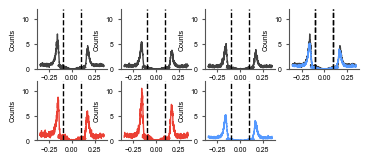

In [3]:
# This plot is overly busy and less interpretable - same numbers than actual figure, just different normalization
import seaborn as sns

fig = subjects.SdFig().fig1_supp(12)

grps_list, zt_list, start_peak, stop_peak, nsesh = [], [], [], [], []
for g, grp in enumerate(["NSD", "SD"]):
    grp_df = ccg_df[ccg_df.grp == grp]
    for z, zt in enumerate(["0-2.5", "2.5-5", "5-7.5"]):
        z_df = grp_df[grp_df.zt == zt].copy()
        ax = plt.subplot(fig.gs[g, z])
        mean_prob = z_df.groupby("time").mean(numeric_only=True).reset_index()

        grps_list.append(grp)
        zt_list.append(zt)
        nsesh.append(len(z_df.session.unique()))
        for c, col in enumerate(["ccg_from_start", "ccg_from_stop"]):
            time = mean_prob["time"].values
            if c == 0:
                time = time - 0.1
                start_peak.append(mean_prob[col].values.max())
            if c == 1:
                time = time + 0.1
                stop_peak.append(mean_prob[col].values.max())

            if grp == "NSD":
                color = subjects.colors_sd(1)[0]
            elif grp == "SD":
                color = subjects.colors_sd(1)[1] if zt in ["0-2.5", "2.5-5"] else subjects.colors_rs(1)[0]
            ax.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
            # ax.plot(time, mean_prob[col].values, lw=1, color=color)
            # ax.set_xlim([-0.03,0.03])
            ax.set_ylim([0, 12])
            ax.ticklabel_format(axis="y", style="scientific")
            # ax.set_title("End of Off period vs Ripples")
            # ax.set_xlabel("Time from start of ripple (ms)")
            ax.set_ylabel("Counts")

        ax.axvline(0.1, ls="--", color="k", lw=1)
        ax.axvline(-0.1, ls="--", color="k", lw=1)

# Plot NSD NS1 versus SD RS1
axbw = plt.subplot(fig.gs[0, 3])
ns1_df = ccg_df[(ccg_df.grp == "NSD") & (ccg_df.zt == "0-2.5")]
rs_df = ccg_df[(ccg_df.grp == "SD") & (ccg_df.zt == "5-7.5")]

for df_use, color in zip([ns1_df, rs_df], [subjects.colors_sd(1)[0], subjects.colors_rs(1)[0]]):
    mean_prob = df_use.groupby("time").mean(numeric_only=True).reset_index()
    for c, col in enumerate(["ccg_from_start", "ccg_from_stop"]):
        time = mean_prob["time"].values
        if c == 0:
            time = time - 0.1
            start_peak.append(mean_prob[col].values.max())
        if c == 1:
            time = time + 0.1
            stop_peak.append(mean_prob[col].values.max())

        # if grp == "NSD":
        #     color = subjects.colors_sd(1)[0]
        # elif grp == "SD":
        #     color = subjects.colors_sd(1)[1] if zt in ["0-2.5", "2.5-5"] else subjects.colors_rs(1)[0]
        axbw.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
        # ax.set_xlim([-0.03,0.03])
        axbw.set_ylim([0, 12])
        axbw.ticklabel_format(axis="y", style="scientific")
        # ax.set_title("End of Off period vs Ripples")
        # ax.set_xlabel("Time from start of ripple (ms)")
        axbw.set_ylabel("Counts")

    axbw.axvline(0.1, ls="--", color="k", lw=1)
    axbw.axvline(-0.1, ls="--", color="k", lw=1)
    

fig.savefig(subjects.figpath_sd / "off_ripple_coupling", format="svg")

# peak_df = pd.DataFrame({"grp": grps_list, "zt": zt_list, "start_peak": start_peak, "stop_peak": stop_peak, "nsessions": nsesh})

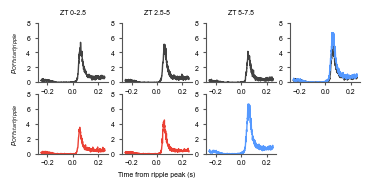

In [4]:
# Plot ripple -> OFF start probability - THIS is the plot used -see bottom for stats
import seaborn as sns

fig = subjects.SdFig().fig1_supp(12)

grps_list, zt_list, poff_peak, nsesh = [], [], [], []
for g, grp in enumerate(["NSD", "SD"]):
    grp_df = ccg_df[ccg_df.grp == grp]
    for z, zt in enumerate(["0-2.5", "2.5-5", "5-7.5"]):
        z_df = grp_df[grp_df.zt == zt].copy()
        ax = plt.subplot(fig.gs[g, z])
        mean_prob = z_df.groupby("time").mean(numeric_only=True).reset_index()

        grps_list.append(grp)
        zt_list.append(zt)
        nsesh.append(len(z_df.session.unique()))
        for c, col in enumerate(["poff_start|ripple"]):
            time = mean_prob["time"].values
            poff_peak.append(mean_prob[col].values.max())

            if grp == "NSD":
                color = subjects.colors_sd(1)[0]
            elif grp == "SD":
                color = subjects.colors_sd(1)[1] if zt in ["0-2.5", "2.5-5"] else subjects.colors_rs(1)[0]
            ax.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
            # ax.plot(time, mean_prob[col].values, lw=1, color=color)
            # ax.set_xlim([-0.03,0.03])
            ax.set_ylim([0, 8])
            ax.ticklabel_format(axis="y", style="scientific")
            # ax.set_title("End of Off period vs Ripples")
            # ax.set_xlabel("Time from start of ripple (ms)")
            if (z == 0):
                ax.set_ylabel("$p_{OFFstart|ripple}$")
            else:
                ax.set_ylabel("")
            if (z == 1) & (g == 1):
                ax.set_xlabel('Time from ripple peak (s)')
            if g == 0:
                ax.set_title(f"ZT {zt}")


# Plot NSD NS1 versus SD RS1
axbw = plt.subplot(fig.gs[0, 3])
ns1_df = ccg_df[(ccg_df.grp == "NSD") & (ccg_df.zt == "0-2.5")]
rs_df = ccg_df[(ccg_df.grp == "SD") & (ccg_df.zt == "5-7.5")]

for df_use, color in zip([ns1_df, rs_df], [subjects.colors_sd(1)[0], subjects.colors_rs(1)[0]]):
    mean_prob = df_use.groupby("time").mean(numeric_only=True).reset_index()
    for c, col in enumerate(["poff_start|ripple"]):
        time = mean_prob["time"].values
        poff_peak.append(mean_prob[col].values.max())

        # if grp == "NSD":
        #     color = subjects.colors_sd(1)[0]
        # elif grp == "SD":
        #     color = subjects.colors_sd(1)[1] if zt in ["0-2.5", "2.5-5"] else subjects.colors_rs(1)[0]
        axbw.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
        # ax.set_xlim([-0.03,0.03])
        axbw.set_ylim([0, 8])
        axbw.ticklabel_format(axis="y", style="scientific")
        # ax.set_title("End of Off period vs Ripples")
        # ax.set_xlabel("Time from start of ripple (ms)")
        # axbw.set_ylabel("Counts")

fig.savefig(subjects.figpath_sd / "ripple_then_off_start_prob", format="svg")

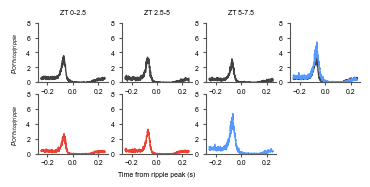

In [5]:
# Plot ripple -> OFF stop probability - Not shown
import seaborn as sns

fig = subjects.SdFig().fig1_supp(12)

grps_list, zt_list, poff_peak, nsesh = [], [], [], []
for g, grp in enumerate(["NSD", "SD"]):
    grp_df = ccg_df[ccg_df.grp == grp]
    for z, zt in enumerate(["0-2.5", "2.5-5", "5-7.5"]):
        z_df = grp_df[grp_df.zt == zt].copy()
        ax = plt.subplot(fig.gs[g, z])
        mean_prob = z_df.groupby("time").mean(numeric_only=True).reset_index()

        grps_list.append(grp)
        zt_list.append(zt)
        nsesh.append(len(z_df.session.unique()))
        for c, col in enumerate(["poff_stop|ripple"]):
            time = mean_prob["time"].values
            poff_peak.append(mean_prob[col].values.max())

            if grp == "NSD":
                color = subjects.colors_sd(1)[0]
            elif grp == "SD":
                color = subjects.colors_sd(1)[1] if zt in ["0-2.5", "2.5-5"] else subjects.colors_rs(1)[0]
            ax.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
            # ax.plot(time, mean_prob[col].values, lw=1, color=color)
            # ax.set_xlim([-0.03,0.03])
            ax.set_ylim([0, 8])
            ax.ticklabel_format(axis="y", style="scientific")
            # ax.set_title("End of Off period vs Ripples")
            # ax.set_xlabel("Time from start of ripple (ms)")
            if (z == 0):
                ax.set_ylabel("$p_{OFFstop|ripple}$")
            else:
                ax.set_ylabel("")
            if (z == 1) & (g == 1):
                ax.set_xlabel('Time from ripple peak (s)')
            if g == 0:
                ax.set_title(f"ZT {zt}")



# Plot NSD NS1 versus SD RS1
axbw = plt.subplot(fig.gs[0, 3])
ns1_df = ccg_df[(ccg_df.grp == "NSD") & (ccg_df.zt == "0-2.5")]
rs_df = ccg_df[(ccg_df.grp == "SD") & (ccg_df.zt == "5-7.5")]

for df_use, color in zip([ns1_df, rs_df], [subjects.colors_sd(1)[0], subjects.colors_rs(1)[0]]):
    mean_prob = df_use.groupby("time").mean(numeric_only=True).reset_index()
    for c, col in enumerate(["poff_stop|ripple"]):
        time = mean_prob["time"].values
        poff_peak.append(mean_prob[col].values.max())

        # if grp == "NSD":
        #     color = subjects.colors_sd(1)[0]
        # elif grp == "SD":
        #     color = subjects.colors_sd(1)[1] if zt in ["0-2.5", "2.5-5"] else subjects.colors_rs(1)[0]
        axbw.plot(time, mean_prob[col].values * 1000, lw=1, color=color)
        # ax.set_xlim([-0.03,0.03])
        axbw.set_ylim([0, 8])
        axbw.ticklabel_format(axis="y", style="scientific")
        # ax.set_title("End of Off period vs Ripples")
        # ax.set_xlabel("Time from start of ripple (ms)")
        # axbw.set_ylabel("Counts")

fig.savefig(subjects.figpath_sd / "ripple_then_off_stop_prob", format="svg")

#### Run Chi-squared 2x2 contingency test for plots above

In [8]:
# Create dfs with counts of total nripples and total noff periods for each group and epoch

ccg_max = ccg_df.groupby(["grp", "zt", "session"]).max().reset_index()
ccg_max_mean = ccg_max.groupby(["grp", "zt"]).mean().reset_index()  # For rough sanity checks
ccg_max_sum = ccg_max.groupby(["grp", "zt"]).sum().reset_index()
ccg_max_sum

,grp,zt,session,ccg_from_start,ccg_from_stop,time,nripple_from_start,nripple_from_stop,noffs,poff_start|ripple,poff_stop|ripple,noff_start_from_ripple,noff_stop_from_ripple,nripple
0,NSD,0-2.5,28,0.065531,0.051639,2.0,263,213,34041,0.050761,0.041136,263,213,41430
1,NSD,2.5-5,28,0.055268,0.042378,2.0,211,158,30389,0.052280,0.039339,211,158,32529
2,NSD,5-7.5,28,0.056546,0.042842,2.0,161,122,22799,0.044860,0.034039,161,122,29360
3,SD,0-2.5,92,0.089352,0.069174,2.0,175,138,16262,0.036025,0.028860,175,138,40378
4,SD,2.5-5,92,0.102039,0.075018,2.0,234,173,19139,0.045808,0.034035,234,173,41656
5,SD,5-7.5,92,0.057526,0.041793,2.0,281,206,39896,0.077311,0.056610,281,206,30767


In [9]:
def chi2_nripple(ccg_max_df, zt1in, grp1in, point1in, zt2in, grp2in, point2in, test="pripple|off"):
    """Perform scipy.stats.chi2_contingency on nripples before/after an off period between two time points.
    Same if test="poff|ripple but for noff periods following a ripple."""
    ccg_df1 = ccg_max_df[(ccg_max_df.zt == zt1in) & (ccg_max_df.grp == grp1in)]
    ccg_df2 = ccg_max_df[(ccg_max_df.zt == zt2in) & (ccg_max_df.grp == grp2in)]
    assert test in ["pripple|off", "poff|ripple"]
    if test == 'pripple|off':
        table = np.array([[ccg_df1[f"nripple_from_{point1in}"].values[0], ccg_df2[f"nripple_from_{point2in}"].values[0]],
                          [ccg_df1.noffs.values[0], ccg_df2.noffs.values[0]]])
    else:
        table = np.array([[ccg_df1[f"noff_{point1in}_from_ripple"].values[0], ccg_df2[f"noff_{point2in}_from_ripple"].values[0]],
                          [ccg_df1.nripple.values[0], ccg_df2.nripple.values[0]]])
    res = stats.chi2_contingency(table)
    return res, table
grp1, grp2 = "NSD", "NSD"
zt1, zt2 = "5-7.5", "5-7.5"
point1, point2 = "start", "stop"
chi2_nripple(ccg_max_sum, zt1, grp1, point1, zt2, grp2, point2)

(Chi2ContingencyResult(statistic=5.069348114310862, pvalue=0.024352540074949247, dof=1, expected_freq=array([[  141.62027855,   141.37972145],
        [22818.37972145, 22779.62027855]])),
 array([[  161,   122],
        [22799, 22799]]))

In [10]:
# Code check for above
grp1, grp2 = "NSD", "NSD"
zt1, zt2 = "5-7.5", "5-7.5"
point1, point2 = "start", "stop"

ccg_df1 = ccg_max_sum[(ccg_max_sum.zt == zt1) & (ccg_max_sum.grp == grp1)]
ccg_df2 = ccg_max_sum[(ccg_max_sum.zt == zt2) & (ccg_max_sum.grp == grp2)]
ccg_df2
table = np.array([[ccg_df1[f"nripple_from_{point1}"].values[0], ccg_df2[f"nripple_from_{point2}"].values[0]],
                  [ccg_df1.noffs.values[0], ccg_df2.noffs.values[0]]])
table
res = stats.chi2_contingency(table)
res

Chi2ContingencyResult(statistic=5.069348114310862, pvalue=0.024352540074949247, dof=1, expected_freq=array([[  141.62027855,   141.37972145],
       [22818.37972145, 22779.62027855]]))

#### **NOT USED:** First check pripple|off

In [11]:
# Loop through each comparison and perform 2x2 chi-square test - for pripple | off
grp1, grp2 = "NSD", "NSD"
zt1, zt2 = "5-7.5", "5-7.5"
point1, point2 = "start", "stop"

grp1_list, grp2_list = [], []
zt1_list, zt2_list = [], []
point1_list, point2_list = [], []
stat_list = []

# 1) ripple prob lower after than before off period
pval_list, grp_list, zt_list, prob_list, pt_list = [], [], [], [], []
for grp in ["NSD", "SD"]:
    for zt in ["0-2.5", "2.5-5", "5-7.5"]:
        point1, point2 = "start", "stop"
        res, table = chi2_nripple(ccg_max_sum, zt, grp, point1, zt, grp, point2)
        pval_list.append(res.pvalue)
        grp_list.append(grp)
        zt_list.append(zt)
        pt_list.append([point1, point2])
        stat_list.append(res.statistic)
        prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
    prob_array = np.array(prob_list)
    pt_array = np.array(pt_list)
df1 = pd.DataFrame({"grp1": grp_list, "zt1": zt_list, "point1": pt_array[:, 0], 
                    "grp2": grp_list, "zt2": zt_list, "point2": pt_array[:, 1],
                    "pvalue": pval_list, "test_stat": stat_list,
                    "prip1": prob_array[:, 0], "prip2": prob_array[:, 1]})

# Comparisons to do: 1) As above but only for 0-2.5
pval_list, grp1_list, grp2_list, zt_list, prob_list, pt_list, stat_list = [], [], [], [], [], [], []
grp1, grp2 = "NSD", "SD"
for zt in ["0-2.5", "2.5-5"]:
    point1, point2 = "start", "stop"
    res, table = chi2_nripple(ccg_max_sum, zt, grp, point1, zt, grp, point2)
    pval_list.append(res.pvalue)
    grp1_list.append("NSD")
    grp2_list.append("SD")
    zt_list.append(zt)
    pt_list.append([point1, point2])
    prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
    stat_list.append(res.statistic)
prob_array = np.array(prob_list)
pt_array = np.array(pt_list)
df1a = pd.DataFrame({"grp1": grp1_list, "zt1": zt_list, "point1": pt_array[:, 0], 
                    "grp2": grp2_list, "zt2": zt_list, "point2": pt_array[:, 1],
                    "pvalue": pval_list, "test_stat": stat_list,
                    "prip1": prob_array[:, 0], "prip2": prob_array[:, 1]})


# 2) Start count for each group from 0-2.5 vs 2.5-5 and 2.5-5 vs 5-7.5
pval_list, grp_list, zt_list, prob_list, pt_list, stat_list = [], [], [], [], [], []
for grp in ["NSD", "SD"]:
    for zt1, zt2 in zip(["0-2.5", "2.5-5", "0-2.5"], ["2.5-5", "5-7.5", "5-7.5"]):
        point1, point2 = "start", "start"
        res, table = chi2_nripple(ccg_max_sum, zt1, grp, point1, zt2, grp, point2)
        pval_list.append(res.pvalue)
        grp_list.append(grp)
        zt_list.append([zt1, zt2])
        pt_list.append([point1, point2])
        prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
        stat_list.append(res.statistic)
    zt_array = np.array(zt_list)
    prob_array = np.array(prob_list)
    pt_array = np.array(pt_list)
df2 = pd.DataFrame({"grp1": grp_list, "zt1": zt_array[:, 0], "point1": pt_array[:, 0], 
                    "grp2": grp_list, "zt2": zt_array[:, 1], "point2": pt_array[:, 1],
                    "pvalue": pval_list, "test_stat": stat_list,
                    "prip1": prob_array[:, 0], "prip2": prob_array[:, 1]})
# 3) RS start vs NS1 start
res, table = chi2_nripple(ccg_max_sum, "0-2.5", "NSD", "start", "5-7.5", "SD", "start")
prob = table[0]/table[1]

off_rip_chi2_df = pd.concat((df1, df1a, df2)).reset_index().drop(columns="index")

off_rip_chi2_df.loc[off_rip_chi2_df.shape[0]] = ["NSD", "0-2.5", "start", "SD", "5-7.5", "start",
                                                 res.pvalue, res.statistic, prob[0], prob[1]]
off_rip_chi2_df.to_csv(subjects.figpath_sd / "off_ripple_coupling_stats.csv")
off_rip_chi2_df


,grp1,zt1,point1,grp2,zt2,point2,pvalue,test_stat,prip1,prip2
0,NSD,0-2.5,start,NSD,0-2.5,stop,2.523526e-02,5.007670,0.007726,0.006257
1,NSD,2.5-5,start,NSD,2.5-5,stop,6.964907e-03,7.281997,0.006943,0.005199
2,NSD,5-7.5,start,NSD,5-7.5,stop,2.435254e-02,5.069348,0.007062,0.005351
3,SD,0-2.5,start,SD,0-2.5,stop,4.291061e-02,4.098920,0.010761,0.008486
4,SD,2.5-5,start,SD,2.5-5,stop,3.097601e-03,8.749070,0.012226,0.009039
5,SD,5-7.5,start,SD,5-7.5,stop,8.293785e-04,11.174307,0.007043,0.005163
6,NSD,0-2.5,start,SD,0-2.5,stop,4.291061e-02,4.098920,0.010761,0.008486
7,NSD,2.5-5,start,SD,2.5-5,stop,3.097601e-03,8.749070,0.012226,0.009039
8,NSD,0-2.5,start,NSD,2.5-5,start,2.687824e-01,1.222950,0.007726,0.006943
9,NSD,2.5-5,start,NSD,5-7.5,start,9.136236e-01,0.011766,0.006943,0.007062


### EDF2H stats **USED** in figure: poff|ripple

In [12]:
# Loop through each comparison and perform 2x2 chi-square test - for poff | ripple
grp1, grp2 = "NSD", "NSD"
zt1, zt2 = "5-7.5", "5-7.5"
point1, point2 = "start", "stop"

grp1_list, grp2_list = [], []
zt1_list, zt2_list = [], []
point1_list, point2_list = [], []
stat_list = []

# # 1) ripple prob lower after than before off period
# pval_list, grp_list, zt_list, prob_list, pt_list = [], [], [], [], []
# for grp in ["NSD", "SD"]:
#     for zt in ["0-2.5", "2.5-5", "5-7.5"]:
#         point1, point2 = "start", "stop"
#         res, table = chi2_nripple(ccg_max_sum, zt, grp, point1, zt, grp, point2, test="poff|ripple")
#         pval_list.append(res.pvalue)
#         grp_list.append(grp)
#         zt_list.append(zt)
#         pt_list.append([point1, point2])
#         stat_list.append(res.statistic)
#         prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
#     prob_array = np.array(prob_list)
#     pt_array = np.array(pt_list)
# df1 = pd.DataFrame({"grp1": grp_list, "zt1": zt_list, "point1": pt_array[:, 0], 
#                     "grp2": grp_list, "zt2": zt_list, "point2": pt_array[:, 1],
#                     "pvalue": pval_list, "test_stat": stat_list,
#                     "prip1": prob_array[:, 0], "prip2": prob_array[:, 1]})

# # Comparisons to do: 1) As above but only for 0-2.5
pval_list, grp1_list, grp2_list, zt_list, prob_list, pt_list, stat_list, phi_list = [], [], [], [], [], [], [], []
grp1, grp2 = "NSD", "SD"
for zt in ["0-2.5", "2.5-5", "5-7.5"]:
    point1, point2 = "start", "start"
    res, table = chi2_nripple(ccg_max_sum, zt, grp1, point1, zt, grp2, point2, test="poff|ripple")
    phi_list.append(np.sqrt(res.statistic / np.sum(table.reshape(-1)) / res.dof))  # calculate effect size
    pval_list.append(res.pvalue)
    grp1_list.append("NSD")
    grp2_list.append("SD")
    zt_list.append(zt)
    pt_list.append([point1, point2])
    prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
    stat_list.append(res.statistic)
prob_array = np.array(prob_list)
pt_array = np.array(pt_list)
df1a = pd.DataFrame({"grp1": grp1_list, "zt1": zt_list, "point1": pt_array[:, 0], 
                    "grp2": grp2_list, "zt2": zt_list, "point2": pt_array[:, 1],
                    "pvalue": pval_list, "test_stat": stat_list,
                    "prip1": prob_array[:, 0], "prip2": prob_array[:, 1],
                    "phi": phi_list})


# 2) Start count for each group from 0-2.5 vs 2.5-5 and 2.5-5 vs 5-7.5
pval_list, grp_list, zt_list, prob_list, pt_list, stat_list, phi_list = [], [], [], [], [], [], []
for grp in ["NSD", "SD"]:
    for zt1, zt2 in zip(["0-2.5", "2.5-5", "0-2.5"], ["2.5-5", "5-7.5", "5-7.5"]):
        for point in ["start"]:
            # point1, point2 = "start", "start"
            point1, point2 = point, point
            
            res, table = chi2_nripple(ccg_max_sum, zt1, grp, point1, zt2, grp, point2, test="poff|ripple")
            phi_list.append(np.sqrt(res.statistic / np.sum(table.reshape(-1)) / res.dof))  # calculate effect size
            pval_list.append(res.pvalue)
            grp_list.append(grp)
            zt_list.append([zt1, zt2])
            pt_list.append([point1, point2])
            prob_list.append(table[0]/table[1]) # Get overall probability as a sanity check
            stat_list.append(res.statistic)
    zt_array = np.array(zt_list)
    prob_array = np.array(prob_list)
    pt_array = np.array(pt_list)
df2 = pd.DataFrame({"grp1": grp_list, "zt1": zt_array[:, 0], "point1": pt_array[:, 0], 
                    "grp2": grp_list, "zt2": zt_array[:, 1], "point2": pt_array[:, 1],
                    "pvalue": pval_list, "test_stat": stat_list,
                    "prip1": prob_array[:, 0], "prip2": prob_array[:, 1],
                    "phi": phi_list})
# 3) RS start vs NS1 start
res, table = chi2_nripple(ccg_max_sum, "0-2.5", "NSD", "start", "5-7.5", "SD", "start", test="poff|ripple")
res2, table2 = chi2_nripple(ccg_max_sum, "0-2.5", "NSD", "stop", "5-7.5", "SD", "stop", test="poff|ripple")
prob = table[0]/table[1]
prob2 = table2[0]/table2[1]
phi = np.sqrt(np.sqrt(res.statistic / np.sum(table.reshape(-1)) / res.dof))  # calculate effect size

rip_off_chi2_df = pd.concat((df1a, df2)).reset_index().drop(columns="index")

rip_off_chi2_df.loc[rip_off_chi2_df.shape[0]] = ["NSD", "0-2.5", "start", "SD", "5-7.5", "start",
                                                 res.pvalue, res.statistic, prob[0], prob[1], phi]
# rip_off_chi2_df.loc[rip_off_chi2_df.shape[0]] = ["NSD", "0-2.5", "stop", "SD", "5-7.5", "stop",
#                                                  res2.pvalue, res2.statistic, prob[0], prob[1]]
rip_off_chi2_df.to_csv(subjects.figpath_sd / "ripple_off_coupling_stats.csv")
rip_off_chi2_df


,grp1,zt1,point1,grp2,zt2,point2,pvalue,test_stat,prip1,prip2,phi
0,NSD,0-2.5,start,SD,0-2.5,start,1.054725e-04,15.036131,0.006348,0.004334,0.013521
1,NSD,2.5-5,start,SD,2.5-5,start,1.431867e-01,2.143374,0.006487,0.005617,0.005359
2,NSD,5-7.5,start,SD,5-7.5,start,2.595401e-07,26.529531,0.005484,0.009133,0.020929
3,NSD,0-2.5,start,NSD,2.5-5,start,8.522009e-01,0.034712,0.006348,0.006487,0.000683
4,NSD,2.5-5,start,NSD,5-7.5,start,1.211296e-01,2.402654,0.006487,0.005484,0.006212
5,NSD,0-2.5,start,NSD,5-7.5,start,1.584207e-01,1.989237,0.006348,0.005484,0.005285
6,SD,0-2.5,start,SD,2.5-5,start,1.087779e-02,6.485173,0.004334,0.005617,0.008869
7,SD,2.5-5,start,SD,5-7.5,start,4.243968e-08,30.034640,0.005617,0.009133,0.020292
8,SD,0-2.5,start,SD,5-7.5,start,4.292651e-15,61.560871,0.004334,0.009133,0.029322
9,NSD,0-2.5,start,SD,5-7.5,start,2.634877e-05,17.664580,0.006348,0.009133,0.124833


In [37]:
zt = "0-2.5"
grp = "NSD"
df_use = ccg_max[(ccg_max.grp == grp) & (ccg_max.zt == zt)]
stats.ttest_rel(df_use.ccg_from_start, df_use.ccg_from_stop, alternative="greater")

TtestResult(statistic=2.2351203133667035, pvalue=0.030255984691231388, df=7)